In [42]:
import pandas as pd
import copy
from openpyxl import Workbook
from openpyxl.workbook.defined_name import DefinedName
import xlsxwriter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [43]:
original_date = datetime(2022, 1, 1, 0, 0, 0)


In [44]:
file = 'D:\WorkKS\Оптимизатор\Данные прототипа_18.БН.xlsx'

In [45]:
def time_convert(array):
    for i in range(len(array)):
        if array[i] != array[i]:
            array[i] = -1
            continue
        date = array[i].split()[0]
        #  print(date)
        day = date.split('.')[0]
        if day[0] == '0':
            day = day[1]
        month = date.split('.')[1]
        if month[0] == '0':
            month = month[1]
        year = date.split('.')[2]
        time = array[i].split()[1]
        hour = time.split(':')[0]
        # if hour[0] == '0':
        #     hour = hour[1]
        minute = time.split(':')[1]
        if minute[0] == '0':
            minute = minute[1]
        day, month, year, hour, minute = int(day) - 1, int(
            month), int(year), int(hour), int(minute)
        if month == 1:
            month = 0
        elif month == 2:
            month = 31
        if month == 3: 
            month = 59
        elif month == 4: 
            month = 90
        elif month == 5: 
            month = 120
        elif month == 6: 
            month = 151
        elif month == 7: 
            month = 181
        elif month == 8: 
            month = 212
        elif month == 9:
            month = 243
        elif month == 10:
            month = 273
        elif month == 11:
            month = 304
        elif month == 12:
            month = 334
        if year % 4 == 0 and month > 50:
            month += 1
        array[i] = year * 365 * 24 + month * 24 + day * 24 + hour + round(minute / 60, 2) - 2022 * 365 * 24
    return array

In [46]:

null_day = int(time_convert(['07.04.2023 00:00'])[0])
# print(null_day)

In [47]:
from time import time


eventSheet = pd.read_excel(rf'{file}', sheet_name=2)
events_df = pd.DataFrame(eventSheet[['id', 'id Мероприятия KS', 'id Мероприятия', 'id Скважины',
                         'id Тип бригады', 'длительность (ч)', 'длительность простоя (ч)', 'Тип', 'Фиксированные периоды',  'Фиксированные часы', 'Фиксированный месяц','Старт простоя через (ч)', 'Начать не раньше', 'Закончить не позже',
                          'datetime_start', 'datetime_end', 'Остановка добычи', 'Влияние на добычу (в периодах после мероприятия, тн/сутки)', 'Бригада', 'do_optimization', 'needs_brigade', 'fan_event', 'system_id',  'is_fact']])
# events_df[['длительность (ч)']] = events_df[['длительность (ч)']].apply(
#     pd.to_numeric, downcast='integer')
fanEvent = list(events_df['fan_event'])
eventID = list(events_df['id'])
event_KS_id = list(events_df['id Мероприятия KS'])
eventSystemId = list(events_df['id Мероприятия'])
well_id = list(events_df['id Скважины'])
brigadetype_id = list(events_df['id Тип бригады'])
downtime = list(events_df['длительность простоя (ч)'])
eventDur = list(events_df['длительность (ч)'])
eventIdSystem = list(events_df['system_id'])
eventType = list(events_df['Тип'])
eventMonth = list(events_df['Фиксированный месяц'])
for i in range(len(eventDur)):
    eventDur[i] = str(eventDur[i])
    try:
        if ',' in eventDur[i]:
            eventDur[i] = round(float(eventDur[i].replace(',', '.')), 2)
        else:
            eventDur[i] = int(eventDur[i])

    except Exception:
        eventDur[i] = round(float(eventDur[i].replace(',', '.')), 2)
    downtime[i] = str(downtime[i])
    try:
        downtime[i] = int(downtime[i])
    except Exception:
        downtime[i] = round(float(downtime[i].replace(',', '.')), 2)
eventIsfixed = list(events_df['Фиксированные периоды'])
eventFixedHours = list(events_df['Фиксированные часы'])
eventIdleStart = list(events_df['Старт простоя через (ч)'])
eventStartLater = list(events_df['Начать не раньше'])
eventFinishEarlier = list(events_df['Закончить не позже'])
eventStart = list(events_df['datetime_start'])
eventFinish = list(events_df['datetime_end'])
eventStart = time_convert(eventStart)
#print(min(eventStart))
eventStartLater = time_convert(eventStartLater)
eventFinishEarlier = time_convert(eventFinishEarlier)
# print(eventStart)
eventOilstop = list(events_df['Остановка добычи'])
oilImpact = list(
    events_df['Влияние на добычу (в периодах после мероприятия, тн/сутки)'])
for i in range(len(oilImpact)):
    try:
        oilImpact[i] = float(oilImpact[i])
    except Exception:
        oilImpact[i] = float(oilImpact[i].replace(',', '.'))
eventCrew = list(events_df['Бригада'])
eventOpt = list(events_df['do_optimization'])
eventBr = list(events_df['needs_brigade'])
eventFact = list(events_df['is_fact'])
for i in range(len(eventCrew)):
    try:
        eventCrew[i] = int(eventCrew[i])
    except Exception:
        eventCrew[i] = 0
event_dur = dict(zip(eventID, eventDur))
event_downtime = dict(zip(eventID, downtime))
event_crewtype = dict(zip(eventID, brigadetype_id))
event_well = dict(zip(eventID, [str(i) for i in well_id]))
event_type = dict(zip(eventID, eventType))
event_month = dict(zip(eventID, eventMonth))
event_isfixed = dict(zip(eventID, eventIsfixed))
# event_start = dict(zip(list(events_df['id']), eventStart))
event_oilstop = dict(zip(eventID, eventOilstop))
event_impact = dict(zip(eventID, oilImpact))
event_crew = dict(zip(eventID, eventCrew))
event_start = dict()
event_fan = dict(zip(eventID, fanEvent))
for i in range(len(eventID)):
    try:
        event_start[eventID[i]] = round(float(eventStart[i]), 3)
    except Exception:
        event_start[eventID[i]] = -1
event_id = dict(zip(eventID, event_KS_id))
# print(event_id)
event_opt = dict(zip(eventID, eventOpt))

event_brig = dict(zip(eventID, eventBr))
event_system = dict(zip(eventID, eventSystemId))
for i in event_system:
    event_system[i] = str(event_system[i])
event_idsystem = dict(zip(eventID, eventIdSystem))
event_fact = dict(zip(eventID, eventFact))
event_FixHours = dict(zip(eventID, eventFixedHours))
event_IdleStart = dict(zip(eventID, eventIdleStart))
event_startlater = dict(zip(eventID, eventStartLater))
event_finishearlier = dict(zip(eventID, eventFinishEarlier))
event_finish = dict(zip(eventID, eventFinish))
keys = list(event_opt.keys())
fan1 = []
for i in event_impact:
    event_impact[i] = round(event_impact[i], 4)
for j in eventSystemId:
    a = []
    for i in event_system:
        if event_opt[i] == 0:
            continue
        if j == event_system[i]:
            try:
                if event_fan[i] == 1:
                    a.append(i)
            except KeyError:
                continue
    if len(a) > 0:
        fan1.append(a)
fan = []
for i in fan1:
    if i not in fan:
        fan.append(i)
#print(fan)
fan_check = []
for i in fan:
    for j in i:
        fan_check.append(j)
# print(event_start)
event_ID = dict(zip(event_KS_id, eventID))


In [48]:
Tuple = pd.read_excel(rf'{file}', sheet_name=4)
Tuple_df = pd.DataFrame(
    Tuple[['кортеж_id', 'кортеж_вариант', 'порядок', 'id Мероприятия KS', 'id', 'id Мероприятия']])
tuple_id = list(Tuple_df['кортеж_id'])
#  print(tuple_id)
tuple_var = list(Tuple_df['кортеж_вариант'])
tuple_order = list(Tuple_df['порядок'])
tuple_event_id = list(Tuple_df['id Мероприятия KS'])
event_tupl = list(Tuple_df['id'])
system = list(Tuple_df['id Мероприятия'])
idSystem = dict(zip(event_tupl, system))
for event in event_tupl:
    event_opt[event] = 1
tuple_event = []
for i in tuple_event_id:
    try:
        tuple_event.append(event_ID[i])
    except Exception:
        print(i)
#  print(tuple_event)
tuples = dict()
prev = tuple_id[0]
val = [tuple_event[0]]
prev_var = tuple_var[0]
for i in range(1, len(tuple_id)):
    if tuple_id[i] == prev:
        if prev_var == tuple_var[i]:
            val.append(tuple_event[i])
        else:
            tuples[prev, prev_var] = val
            val = []
            val.append(tuple_event[i])
    else:
        tuples[prev, prev_var] = val
        val = []
        val.append(tuple_event[i])
    prev = tuple_id[i]
    prev_var = tuple_var[i]
tuples[prev, prev_var] = val
#  print(tuples)

In [49]:
WellSheet = pd.read_excel(rf'{file}', sheet_name=0)
well_df = pd.DataFrame(WellSheet[['id Скважины', 'Дебит нефти (ТР)', 'Статус скважины']])
well_id = [str(i) for i in list(well_df['id Скважины'])]
well_production = list(well_df['Дебит нефти (ТР)'])
wellStatus = list(well_df['Статус скважины'])
well_status = dict(zip(well_id, wellStatus))
for i in range(len(well_production)):
    # print(well_production[i])
    try:
        well_production[i] = well_production[i].replace(',', '.')
    except AttributeError:
        pass
    if well_production[i] != well_production[i]:
        well_production[i] = 0
    well_production[i] = float(well_production[i])

wellProd1 = dict(zip(well_id, well_production))
wellProd = {k: v for k, v in wellProd1.items()}
# print(wellProd)
a = 0
for i in wellProd:
    a += wellProd[i]
    a = round(a, 3)
# print(a)

In [50]:
crewSheet = pd.read_excel(rf'{file}', sheet_name=1)

crew_df = pd.DataFrame(
    crewSheet[['id', 'id Типа бригады', 'Имя Исполнителя', 'Номер бригады', 'Статус']])

listOfCrews = list(crew_df['id'])
idTypeOfCrew = list(crew_df['id Типа бригады'])
crewName = list(crew_df['Имя Исполнителя'])
crewNumber = list(crew_df['Номер бригады'])
crewStatus = list(crew_df['Статус'])
crew_Status = dict(zip(listOfCrews, crewStatus))
crewIDtoCrews = dict()
crewToCrewID = dict(zip(listOfCrews, idTypeOfCrew))
for crew, crewId in zip(listOfCrews, idTypeOfCrew):
    if crewId in crewIDtoCrews:
        if crew_Status[crew] == 1:
            crewIDtoCrews[crewId].append(crew)
    else:
        crewIDtoCrews[crewId] = []
        crewIDtoCrews[crewId].append(crew)
crew_name = dict(zip(listOfCrews, crewName))
crew_num = dict(zip(listOfCrews, crewNumber))
crew_name[-1] = -1
crew_num[-1] = -1
crewIDtoCrews = dict(crewIDtoCrews)
# print(type(crewIDtoCrews))
# print(crewIDtoCrews)
crewIDtoEvent = dict()
for i, j in zip(eventID, brigadetype_id):
    if j not in crewIDtoEvent.keys():
        crewIDtoEvent[j] = []
    crewIDtoEvent[j].append(i)
# print(crew_Status)
# print(crewIDtoEvent)
# print(crewToCrewID)
# print(crewIDtoCrews)


In [51]:
ParallelSheet = pd.read_excel(rf'{file}', sheet_name=3)
parallel_df = pd.DataFrame(ParallelSheet[['event_id1', 'event_id2']])
event_id1 = list(parallel_df['event_id1'])
event_id2 = list(parallel_df['event_id2'])
parallel = []
for i in range(len(event_id1)):
    a, b = min(event_id1[i], event_id2[i]), max(event_id1[i], event_id2[i])
    parallel.append((a, b))
# print(parallel)
par_check = []
for i in parallel:
    par_check.append(i[0])
    par_check.append(i[1])

In [52]:
DistSheet = pd.read_excel(rf'{file}', sheet_name=5)
dist_df = pd.DataFrame(DistSheet[['well_id1', 'well_id2', 'dist(hr)', 'dist (m)']])
well_id1 = list(dist_df['well_id1'])
well_id2 = list(dist_df['well_id2'])
distm = list(dist_df['dist (m)'])
dist = list(dist_df['dist(hr)'])
for i in range(len(dist)):
    try:
        distm[i] = int(distm[i])
        dist[i] = int(dist[i])
    except Exception:
        dist[i] = float(dist[i].replace(',', '.'))
        distm[i] = float(distm[i].replace(',', '.'))
distance = dict(
    zip(zip([str(i) for i in well_id1], [str(j) for j in well_id2]), dist))
mdistance = dict(
    zip(zip([str(i) for i in well_id1], [str(j) for j in well_id2]), distm))
# print(distance)


In [53]:
# SettingsSheet = pd.read_excel(rf'{file}', sheet_name=9)
# settings_df = pd.DataFrame(SettingsSheet[['Выработка в сутки', '% достимого отклонения суточной добычи от цели']])
# production = int(settings_df['Выработка в сутки'])
# deviation = int(settings_df['% достимого отклонения суточной добычи от цели'])
# print(fan)


In [54]:
production = 0
for i in well_id:
    if well_status[i] == 1:
        production += wellProd[i]
production = round(production, 2)
# print(production)
deviation = 5
fan_deviation = 20

In [55]:
planned_events = dict(zip(eventID, [{'start': -1, 'finish': -1, 'brig': -1} for i in range(len(eventID))]))
brigade_plan = dict(zip(listOfCrews, [[[-1, -1, 'Положительная 1', 0]] for i in range(len(listOfCrews))]))
well_prod = dict(zip(well_id, [[[0, 0]] for i in range(len(well_id))]))
#print(well_prod)
for i in well_prod:
    if well_status[i] == 1:
        well_prod[i] = [[wellProd[i], wellProd[i]]]
    else:
        well_prod[i]  = [[0, wellProd[i]]]
    for j in range(94):
        well_prod[i].append(well_prod[i][0].copy())
#print('------------------')
#print(well_prod)
oil_prod = [0 for i in range(95)]
for i in well_prod:
    for j in range(len(well_prod[i])):
        oil_prod[j] += well_prod[i][j][0]
# print(well_prod)
# print('-------------------------------------------------------------')
# print(oil_prod)
# print(well_prod)
days_num = 95

In [56]:
# 2448 - 20.10.2022 00:00
# 3144 - 18.11.2022 00:00

def oil_production():
    oil_prod = [0 for i in range(days_num)]
    for i in well_prod:
        for j in range(len(well_prod[i])):
            oil_prod[j] += well_prod[i][j][0]
    return oil_prod


def well_rewrite(well, start, dur, vnr, tup, impact):
    global well_prod, oil_prod
    start1 = int((start - null_day) // 24)
    start2 = int(start - null_day)
    end = start2 + dur
    startHourAtDay = start2 % 24
    diffStart = 24 - startHourAtDay
    diffEnd = (startHourAtDay + dur) % 24
    
    if end < 0:
        if tup[0] == 1:
            if tup[1] == 0:
                for i in range(days_num):
                    well_prod[well][i][0] = 0
        if vnr == 2:
            for i in range(days_num):
                well_prod[well][i][0] = 0
                well_prod[well][i][1] = 0
        oil_prod = oil_production()
        return True
    if start2 < 0:
        
        if tup[0] == 1:
           
            if tup[1] == 0:
                
                for i in range(days_num):
                    well_prod[well][i][0] = 0
                oil_prod = oil_production()
                return True
        if end // 24 > days_num:
            for i in range(start1, days_num):
                well_prod[well][i][0] = 0
            oil_prod = oil_production()
            return True
        i = 0
        startHourAtDay = start2 % 24
        diffStart = 24 - startHourAtDay
        diffEnd = (startHourAtDay + dur) % 24
        if end % 24 == 0:
            while i < end // 24:
                well_prod[well][i][0] = 0
                i += 1
        else:
            while i <= (end - 1) // 24:
                if (end - 1) // 24 == i:
                    well_prod[well][i][0] -= diffEnd / 24 * well_prod[well][i][0]
                else:
                    well_prod[well][i][0] = 0
                i += 1
        if vnr == 2:
            for i in range(days_num):
                well_prod[well][i][0] = 0
                well_prod[well][i][1] = 0
        if impact != 0:
            if diffEnd != 0:
                well_prod[well][int(start2 + dur) //
                                24][0] += (24 - diffEnd) / 24 * impact
                well_prod[well][int(start2 + dur) // 24][1] += impact
                for i in range(int(start2 + dur) // 24 + 1, days_num):
                    well_prod[well][i][0] += impact
                    well_prod[well][i][1] += impact
            else:
                for i in range(int(start2 + dur) // 24, days_num):
                    well_prod[well][i][0] += impact
                    well_prod[well][i][1] += impact
        oil_prod = oil_production()
        return True
    if tup[0] == 1:
        if tup[1] == 0:
            startHourAtDay = start2 % 24
            diffStart = 24 - startHourAtDay
            
            well_prod[well][max(start1, 0)][0] -= diffStart / 24 * well_prod[well][start1][0]
            for i in range(max(start1 + 1, 1), days_num):
                well_prod[well][i][0] = 0
            oil_prod = oil_production()
            return True
    if vnr == 2:
        startHourAtDay = start2 % 24
        if startHourAtDay + dur <= 24:
            well_prod[well][start1][0] -= dur / 24 * well_prod[well][start1][0]
            for i in range(max(start1 + 1, 1), days_num):
                well_prod[well][i][0] = 0
            oil_prod = oil_production()
            return True
        elif startHourAtDay + dur > 24:
            i = start1
            diffStart = 24 - startHourAtDay
            diffEnd = (startHourAtDay + dur) % 24
            if start1 == i:
                well_prod[well][i][0] -= diffStart / 24 * well_prod[well][i][0]
            i += 1
            while i < days_num:
                # print('i -', i)
                well_prod[well][i][0] = 0
                well_prod[well][i][1] = 0
                i += 1
            oil_prod = oil_production()
            return True
    if vnr == 0:
        # if start % 24 != 0:
        #     well_prod[well][start1][0] -= (24 - start % 24) / 24 * well_prod[well][start1][0]
        # else:
        #     well_prod[well][start1][0] = 0
        # for i in range(start1, (start2 + dur)// 24)
        # for i in range(start1 + 1, len(well_prod[well])):
        startHourAtDay = start2 % 24
        if startHourAtDay + dur <= 24:
            well_prod[well][start1][0] -= dur / 24 * well_prod[well][start1][0]
            if impact != 0:
                if diffEnd != 0:
                    well_prod[well][int((start2 + dur) //
                                    24)][0] += (24 - diffEnd) / 24 * impact
                    well_prod[well][int((start2 + dur) // 24)][1] += impact
                    for i in range(int(start2 + dur) // 24 + 1, days_num):
                        well_prod[well][i][0] += impact
                        well_prod[well][i][1] += impact
                else:
                    for i in range(int(start2 + dur) // 24, days_num):
                        well_prod[well][i][0] += impact
                        well_prod[well][i][1] += impact
            oil_prod = oil_production()
            return True
        elif startHourAtDay + dur > 24:
            if end // 24 > days_num:
                for i in range(start1, days_num):
                    well_prod[well][i][0] = 0
                oil_prod = oil_production()
                return True
            i = start1
            diffStart = 24 - startHourAtDay
            diffEnd = (startHourAtDay + dur) % 24
            while i <= (end - 1) // 24:
                # print(i)
                if start1 == i:
                    well_prod[well][i][0] -= diffStart / \
                        24 * well_prod[well][i][0]
                elif (end - 1) // 24 == i:
                    well_prod[well][i][0] -= diffEnd / \
                        24 * well_prod[well][i][0]
                else:
                    well_prod[well][i][0] = 0
                i += 1
            if impact != 0:
                if diffEnd != 0:
                    well_prod[well][int(start2 + dur) //
                                    24][0] += (24 - diffEnd) / 24 * impact
                    well_prod[well][int(start2 + dur) // 24][1] += impact
                    for i in range(int(start2 + dur) // 24 + 1, days_num):
                        well_prod[well][i][0] += impact
                        well_prod[well][i][1] += impact
                else:
                    for i in range(int(start2 + dur) // 24, days_num):
                        well_prod[well][i][0] += impact
                        well_prod[well][i][1] += impact
                

            oil_prod = oil_production()
            return True
    else:
        startHourAtDay = start2 % 24
        diffStart = 24 - startHourAtDay
        diffEnd = (startHourAtDay + dur) % 24
        i = start1

        for h in range(start2, min(int(start2 + dur), (days_num - 1)*24)):
            if h // 24 == int(start2 + dur) // 24 or dur // 24 - (h // 24 - start1) == 0:
                break
            if dur // 24 - (h // 24 - start1) == 1:
                #
                well_prod[well][h // 24][0] += round(well_prod[well][h // 24][1] / 24, 3)
                well_prod[well][h // 24][0] = round(well_prod[well][h // 24][0], 2)
            else:
                well_prod[well][h // 24][0] += round(well_prod[well][h // 24][1] / (
                    dur // 24 - (h // 24 - start1)) * 1.9 / 24, 3)
                well_prod[well][h // 24][0] = round(well_prod[well][h // 24][0], 2)
        for i in range(int(start2 + dur) // 24, days_num):
            well_prod[well][i][0] = well_prod[well][i][1]
        if impact != 0:
            if diffEnd != 0:
                if days_num * 24 > int(start2 + dur):
                    well_prod[well][int(start2 + dur) //
                                    24][0] += (24 - diffEnd) / 24 * impact
                    well_prod[well][int(start2 + dur) // 24][1] += impact
                    for i in range(int(start2 + dur) // 24 + 1, days_num):
                        well_prod[well][i][0] += impact
                        well_prod[well][i][1] += impact
            else:
                for i in range(int(start2 + dur) // 24, days_num):
                    well_prod[well][i][0] += impact
                    well_prod[well][i][1] += impact
        oil_prod = oil_production()
        
        return True


def tup_definition(id):
    tup = 0
    pos = 0
    if id in tuple_event:
        tup = 1
        for j in tuples:
            if id in tuples[j]:
                if tuples[j].index(id) != len(tuples[j]) - 1:
                    pos = 0
                    return [tup, pos]
                else:
                    pos = 1
                    return [tup, pos]
    else:
        return [0, 0]


def sort_brig(brig):
    global brigade_plan
    brigade_plan[brig] = sorted(brigade_plan[brig])
    return True


In [57]:
# functions
def month(start):
    year = int(round(start // (365 * 24)))
    start %= (365 * 24)
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    if year % 4 == 0:
        months[1] += 1
    month = 1
    val = 0
    for i in range(len(months)):
        if months[i] * 24 + val > start:
            return i + 1 + year * 12
        else:
            val += months[i] * 24

def hour(month):
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    hour = 0
    for i in range(month - 1):
        if i % 24 == 0 and i != 0:
            hour += 24
        hour += months[i % 12] * 24
    hour += months[(month - 1) % 12] * 24
    return hour
        
        

def write(id, start, brig):
    global planned_events
    global brigade_plan
    planned_events[id]['start'] = start
    planned_events[id]['finish'] = round(start + event_dur[id], 2)
    if brig != 0:
        planned_events[id]['brig'] = brig
        brigade_plan[brig].append([start, start + event_dur[id], event_well[id], 0 if event_system[id] != '77777' else 1])
        sort_brig(brig)
    if event_oilstop[id] == 1:
        if event_fact[id] == 0 or event_type[id] == 2:
            # print([event_well[id], start, event_dur[id], event_type[id], tup_definition(id), event_impact[id]])
            well_rewrite(event_well[id], start + event_IdleStart[id], event_downtime[id], event_type[id], tup_definition(id), event_impact[id])
    if id in fan_check:
        for i in fan:
            if id in i:
                if planned_events[i[0]]['start'] == -1:
                    for j in range(len(i)):
                        write(i[j], start, 0)
                else:
                    return True
    return True    
        

def brig_availability(id, start):
    res = []
    if event_crew[id] != 0:
        available = True
        for i in range(len(brigade_plan[event_crew[id]])):
            # print(i, start)
            if i == len(brigade_plan[event_crew[id]]) - 1:
                if brigade_plan[event_crew[id]][i][0] > start:
                    if start + event_dur[id] + distance[(brigade_plan[event_crew[id]][i][2], event_well[id])] <= brigade_plan[event_crew[id]][i][0]:
                        if brigade_plan[event_crew[id]][i - 1][1] + distance[(brigade_plan[event_crew[id]][i - 1][2], event_well[id])] <= start:
                            return [[event_crew[id]]]
                        else:
                            return False
                    else:
                        return False
                elif brigade_plan[event_crew[id]][i][1] + distance[(brigade_plan[event_crew[id]][i][2], event_well[id])] <= start:
                    return [[event_crew[id]]]
            elif brigade_plan[event_crew[id]][i][0] > start:
                if start + event_dur[id] + distance[(brigade_plan[event_crew[id]][i][2], event_well[id])] <= brigade_plan[event_crew[id]][i][0]:
                    if brigade_plan[event_crew[id]][i - 1][1] + distance[(brigade_plan[event_crew[id]][i - 1][2], event_well[id])] <= start:
                        return [[event_crew[id]]]
                    else:
                        return False
                else:
                    return False
    else:
        month1 = month(start)
        for j in brigade_plan:
            if crew_Status[j] == 0:
                continue
            if event_crewtype[id] == crewToCrewID[j]:
                if event_system[id] == '777777':
                    s = 0
                    for i in brigade_plan[j]:
                        if 'Положительная' in i[2]:
                            if month(i[0]) == month1:
                                s += 1
                    if s > 1:
                        continue
                # print('v availability', j)
                for i in range(len(brigade_plan[j])):
                    if i == len(brigade_plan[j]) - 1:
                        if brigade_plan[j][i][0] > start:
                            if start + event_dur[id] + distance[(brigade_plan[j][i][2], event_well[id])] <= brigade_plan[j][i][0]:
                                if brigade_plan[j][i - 1][1] + distance[(brigade_plan[j][i - 1][2], event_well[id])] <= start:
                                    res.append([j, distance[(brigade_plan[j][i - 1][2], event_well[id])], start - brigade_plan[j][i - 1][1]])
                                    break
                                else:
                                    break
                            else:
                                break
                        elif brigade_plan[j][i][1] + distance[(brigade_plan[j][i][2], event_well[id])] <= start:
                            res.append([j, distance[(brigade_plan[j][i][2], event_well[id])], start - brigade_plan[j][i - 1][1]])
                            break
                    elif brigade_plan[j][i][0] > start:
                        if start + event_dur[id] + distance[(brigade_plan[j][i][2], event_well[id])] <= brigade_plan[j][i][0]:
                            if brigade_plan[j][i - 1][1] + distance[(brigade_plan[j][i - 1][2], event_well[id])] <= start:
                                res.append([j, distance[(brigade_plan[j][i- 1][2], event_well[id])], start - brigade_plan[j][i - 1][1]])
                                break
                            else:
                                break
                        else:
                            break
    if len(res) == 0:
        return False
    res = sorted(res, key = lambda i: i[2])                   
    return res


def brig_lookup(id, start):
    if event_crewtype[id] == 5:
        return 0
    if event_crewtype[id] == 1:
        # сделать не хардкод буровиков!
        return 15
    # print('v lookupe',id, start)
    a = brig_availability(id, start)
    if a is False:
        return False
    else:
        # print(a)
        return a[0][0]



In [58]:
# functions
def oil_check(id, start):
    global oil_prod
    start += event_IdleStart[id]
    print(event_well[id], int(start - null_day) // 24, start, id)
    if well_prod[event_well[id]][int(start - null_day) // 24][1] == 0:
        return True
    res = True
    for i in range(int(start - null_day) // 24, int(start - null_day + event_downtime[id] - 1) // 24):
        if i >= 92:
            # print('proshel oil_check 2')
            return True
        print(i)
        if oil_prod[i] - well_prod[event_well[id]][i][1] < production * (100 - deviation) / 100:
            print(i, oil_prod[i], well_prod[event_well[id]][i][1], production * (100 - deviation) / 100)
            res = False
            break
    if res:
        # print('прошел ойл чек')
        return True
    else:
        if event_downtime[id] > 47:
            # print('ne proshel oil_check 1')
            return False
        else:
            well_prod_copy = copy.deepcopy(well_prod)
            oil_prod_copy = copy.deepcopy(oil_prod)
            start2 = int(start) - null_day
            start1 = start2 // 24
            startHourAtDay = start2 % 24
            dur = event_downtime[event]
            end = start2 + dur
            if startHourAtDay + dur <= 24:
                well_prod_copy[event_well[id]][start1][0] -= dur / 24 * well_prod[event_well[id]][start1][0]
            elif startHourAtDay + dur > 24:
                i = start1
                diffStart = 24 - startHourAtDay
                diffEnd = (startHourAtDay + dur) % 24
                while i <= (end - 1) // 24:
                    # print(i)
                    if start1 == i:
                        well_prod_copy[event_well[id]][i][0] -= diffStart / 24 * well_prod_copy[event_well[id]][i][0]
                    elif (end - 1) // 24 == i:
                        well_prod_copy[event_well[id]][i][0] -= diffEnd / 24 * well_prod_copy[event_well[id]][i][0]
                    else:
                        well_prod_copy[event_well[id]][i][0] = 0
                    i += 1
            oil_prod_copy = [0 for i in range(92)]
            for i in well_prod_copy:
                for j in range(len(well_prod_copy[i])):
                    oil_prod_copy[j] += well_prod_copy[i][j][0]
            for i in range(len(oil_prod_copy)):
                if oil_prod_copy[i] < production * (100 - deviation) / 100:
                    # print('ne proshel oil_check 3')
                    return False
            # print('oil_check прошел')
            return True


def oil_fan_check(ind, start):
    
        

    return True


def possible(event, well, start, dur):
    if planned_events[event]['start'] != -1:
        return False
    if event_system[event] == '777777':
        return unnum_possible(start)
    if well == '0':
        return True
    else:
        if event_idsystem[event] == 3:
            if int(start) % 24 != int(event_start[event]) % 24:
                return False
        sim = 0
        if event in par_check:
            for j in parallel:
                if event == j[0]:
                    sim = j[1]
                elif event ==  j[1]:
                    sim = j[0]
        for i in planned_events: 
            if event_well[i] == well:
                if start + dur > planned_events[i]['start'] and start < planned_events[i]['finish'] and i != sim:
                    return False
            elif start + dur > planned_events[i]['start'] and start < planned_events[i]['finish'] and mdistance[event_well[i], well] < 15 and event_idsystem[i] == 2 and event_idsystem[event] == 2 and event_type[i] == 0 and event_system[i] != '777777':
                return False
    return True

# def simops(id, start):
#     if event_fact[id] == 1:
#         return True
#     if start + event_dur[id] < null_day:
#         return True
#     if id in par_check:
#         for i in parallel:
#             if id == i[0]:
#                 sim = i[1]
#             elif id ==  i[1]:
#                 sim = i[0]
#     else:
#         return True
#     if event_idsystem[sim] == 2:
#         return True
#     if event_system[id] == 2:
#         if start >= null_day:
#             if event_dur[sim] < event_dur[id]:
#                 for h in range(start, event_dur[id] + start):
#                     if possible(sim, event_well[sim], h, event_dur[sim]):
#                         write(sim, start, 0)
#                         break
#             else:
                


                    
def unnum_possible(h):
    h1 = (h  - null_day)// 24
    for i in planned_events:
        if event_system[i] == '777777' and event_type[i] == 0:
            day = (planned_events[i]['start'] - null_day) // 24
            # print('day', i, day)
            if day == h1:
                return False
    return True 

In [59]:
# 1
for i in eventID:
    if event_fact[i] == 1:
        write(i, event_start[i], event_crew[i])
        # print('zapisal', i, event_start[i])

                    

In [60]:
# 2
for i in eventID:
    if event_fact[i] == 0 and event_opt[i] == 1 and event_isfixed[i] == 1:
        
        brig = brig_lookup(i, event_start[i])
        if brig is False:
            print(i, 'brigade not found')
        else:
            write(i, event_start[i], brig)
            # print(i, 'zapisal', event_start[i], brig)

print('-----------------------')
for i in eventID:
    if event_fact[i] == 1:    
        if i in tuple_event:
            for j in tuples:
                if i in tuples[j]:
                    a = False
                    for k in tuples[j]:
                        if event_fact[k] == 1:
                            continue
                        else:
                            if event_isfixed[k] == 1 or event_type[k] == 2:
                                continue
                            else:
                                a = True
                                for p in range(tuples[j].index(k), len(tuples[j])):
                                    if planned_events[tuples[j][p]]['start'] != -1:
                                        continue
                                    elif event_type[tuples[j][p]] == 1:
                                        write(tuples[j][p], planned_events[tuples[j][p-1]]['finish'], 0)
                                        continue
                                    if int(planned_events[tuples[j][p - 1]]['finish']) == planned_events[tuples[j][p - 1]]['finish']:
                                        fin = int(planned_events[tuples[j][p - 1]]['finish'])
                                    else:
                                        fin = int(planned_events[tuples[j][p - 1]]['finish']) + 1
                                    fin = max(fin, null_day + 24, 0 if event_isfixed[tuples[j][p - 1]] == 0 else event_start[tuples[j][p - 1]] + event_dur[tuples[j][p - 1]])
                                    if fin != int(fin):
                                        fin = int(fin) + 1
                                    else:
                                        fin = int(fin)
                                    # print(tuples[j][p - 1], fin, event_start[tuples[j][p - 1]], event_dur[tuples[j][p - 1]], event_isfixed[tuples[j][p - 1]])
                                    for h in range(fin, fin + 500):
                                        brig = brig_lookup(tuples[j][p], h)
                                        if brig is False or not possible(tuples[j][p], event_well[tuples[j][p]], h, event_dur[tuples[j][p]]):
                                            continue
                                        else:
                                            write(tuples[j][p], h, brig)
                                            # print(tuples[j][p], 'zapisal', h)
                                            break
                        if a:
                            break
print('---------------------------------------------------------------')
for i in eventID:
    if event_fact[i] == 0 and event_opt[i] == 1 and event_isfixed[i] == 1:
        if i in tuple_event:
            for j in tuples:
                if i in tuples[j]:
                    length = len(tuples[j])
                    pos = tuples[j].index(i)
                    if pos != length - 1:
                        for o in range(pos + 1, length):
                            if planned_events[tuples[j][o]]['start'] != -1:
                                continue
                            elif event_type[tuples[j][o]] == 1:
                                write(tuples[j][o], planned_events[tuples[j][o - 1]]['finish'], 0)
                                continue
                            if int(planned_events[tuples[j][o - 1]]['finish']) == planned_events[tuples[j][o - 1]]['finish']:
                                fin = int(planned_events[tuples[j][o - 1]]['finish'])
                            else:
                                fin = int(planned_events[tuples[j][o - 1]]['finish']) + 1
                            # print(tuples[j][o],'-', fin)
                            # print(planned_events[tuples[j][o - 1]], '-', tuples[j][o - 1])
                            if fin < null_day + 24:
                                fin = null_day + 24
                            # print(tuples[j][o], fin, planned_events[tuples[j][o]])
                            for h in range(fin, fin + 500):
                                if oil_check(tuples[j][o], h):
                                    brig = brig_lookup(tuples[j][o], h)
                                    # print(brig, tuples[j][o], h)
                                    if brig is False or not possible(tuples[j][o], event_well[tuples[j][o]], h, event_dur[tuples[j][o]]):
                                        # print('zdes', tuples[j][o], h, possible(tuples[j][o], event_well[tuples[j][o]], h, event_dur[tuples[j][o]]))
                                        continue
                                    else:
                                        write(tuples[j][o], h, brig)
                                        # print(tuples[j][o], 'zapisal1', h, brig)
                                        break
                    else:
                        # for o in range(pos - 1, -1, -1):
                        #     if planned_events[tuples[j][o]]['start'] != -1:
                        #         continue

                        if planned_events[tuples[j][pos]]['start'] != -1:
                            continue
                        elif event_type[tuples[j][pos]] == 1:
                            write(tuples[j][pos], planned_events[tuples[j][pos - 1]]['finish'], 0)
                            continue
                        if int(planned_events[tuples[j][pos - 1]]['finish']) == planned_events[tuples[j][pos - 1]]['finish']:
                            fin = int(planned_events[tuples[j][pos - 1]]['finish'])
                        else:
                            fin = int(planned_events[tuples[j][pos - 1]]['finish']) + 1
                        if fin < null_day + 24:
                            fin = null_day + 24
                        for h in range(fin, fin + 500):
                            if oil_check(tuples[j][pos], h):
                                brig = brig_lookup(tuples[j][pos], h)
                                if brig is False or not possible(tuples[j][pos], event_well[tuples[j][pos]], h, event_dur[tuples[j][pos]]):
                                    continue
                                else:
                                    write(tuples[j][pos], h, brig)
                                    break
                    break


-----------------------
---------------------------------------------------------------
4709 1 11088 22
1
2
прошел ойл чек
4441 72 12804 5
72
73
74
75
76
77
78
прошел ойл чек
4326 1 11088 49
1
2
3
4
5
прошел ойл чек
4326 1 11089 49
1
2
3
4
5
прошел ойл чек
4326 1 11090 49
1
2
3
4
5
прошел ойл чек
4326 1 11091 49
1
2
3
4
5
прошел ойл чек
4326 1 11092 49
1
2
3
4
5
прошел ойл чек
4326 1 11093 49
1
2
3
4
5
прошел ойл чек
4326 1 11094 49
1
2
3
4
5
прошел ойл чек
4326 1 11095 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11096 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11097 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11098 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11099 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11100 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11101 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11102 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11103 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11104 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11105 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11106 49
1
2
3
4
5
6
прошел ойл чек
4326 1 11107 49
1
2
3


In [61]:
for i in planned_events:
    if event_idsystem[i] == 1 and event_fact[i] == 0:

        print(planned_events[i])

{'start': 10848.0, 'finish': 11073.37, 'brig': 15}
{'start': 12552.0, 'finish': 13344.0, 'brig': 15}
{'start': 10544.13, 'finish': 12191.98, 'brig': 15}
{'start': 11496.0, 'finish': 12804.0, 'brig': 15}
{'start': 11088.0, 'finish': 12528.0, 'brig': 15}
{'start': 10560.0, 'finish': 10992.0, 'brig': 15}
{'start': 11352.0, 'finish': 12241.0, 'brig': 15}
{'start': 10607.0, 'finish': 11892.0, 'brig': 15}
{'start': 10608.0, 'finish': 12120.0, 'brig': 15}
{'start': 10578.0, 'finish': 10932.0, 'brig': 15}
{'start': 11280.0, 'finish': 12552.0, 'brig': 15}
{'start': 10356.0, 'finish': 11604.0, 'brig': 15}
{'start': 10392.0, 'finish': 10809.35, 'brig': 15}
{'start': 11880.0, 'finish': 12192.0, 'brig': 15}
{'start': 10440.0, 'finish': 11352.0, 'brig': 15}
{'start': 10848.0, 'finish': 13092.0, 'brig': 15}
{'start': 10416.0, 'finish': 11904.0, 'brig': 15}
{'start': 9637.0, 'finish': 12612.0, 'brig': 15}
{'start': 11520.0, 'finish': 12528.0, 'brig': 15}
{'start': 11712.0, 'finish': 13080.0, 'brig': 1

In [62]:
for i in eventID:
    if event_fact[i] == 0 and event_opt[i] == 1 and event_isfixed[i] == 1:
        if i in tuple_event:
            for j in tuples:
                if i in tuples[j]:
                    for k in tuples[j]:
                        if planned_events[k]['start'] == -1:
                            print(k)
                        else:
                            print(k, planned_events[k], event_fact[k], event_isfixed[k])
                    print('-----------')
for i in eventID:
    if event_isfixed[i] == 1:
        print(i, planned_events[i], event_opt[i])

17 {'start': 10848.0, 'finish': 11073.37, 'brig': 15} 0 1
22 {'start': 11088, 'finish': 11160.0, 'brig': 11} 0 0
108 {'start': 11160.0, 'finish': 11376.0, 'brig': -1} 0 0
-----------
244 {'start': 10032.0, 'finish': 10188.0, 'brig': 9} 1 1
30 {'start': 10392.0, 'finish': 10512.0, 'brig': -1} 0 1
-----------
50 {'start': 11496.0, 'finish': 12804.0, 'brig': 15} 0 1
5 {'start': 12804, 'finish': 12965.0, 'brig': 6} 0 0
-----------
76 {'start': 10578.0, 'finish': 10932.0, 'brig': 15} 0 1
49 {'start': 11397, 'finish': 11535.0, 'brig': 6} 0 0
43 {'start': 11535.0, 'finish': 11835.0, 'brig': -1} 0 0
-----------
89 {'start': 10356.0, 'finish': 11604.0, 'brig': 15} 0 1
165 {'start': 11604, 'finish': 11765.0, 'brig': 6} 0 0
-----------
97 {'start': 10392.0, 'finish': 10809.35, 'brig': 15} 0 1
9 {'start': 11160, 'finish': 11232.0, 'brig': 9} 0 0
34 {'start': 11232.0, 'finish': 11424.0, 'brig': -1} 0 0
-----------
121 {'start': 10440.0, 'finish': 11352.0, 'brig': 15} 0 1
77 {'start': 11535, 'finish

In [63]:
def search(a, k):
    if len(a) == 0:
        return True
    for i in a:
        if k in i:
            return False
    return True

In [64]:
# 3
for i in eventID:
    if event_opt[i] == 1:
        if planned_events[i]['start'] == -1:
            if event_type[i] == 2:
                # print('--------------')

                month1 = month(event_start[i])
                hour1 = hour(month1)
                # print(month1, hour1)
                # print(month1, hour1)
                # print(null_day)
                # print(event_dur[i])
                # print(hour(month1-1))
                # print(int(hour1 - event_dur[i]), max(hour(month1 - 1), null_day + 24))
                # for j in brigade_plan:
                #     if crewToCrewID[j] == 4:
                #         print(j, brigade_plan[j])

                
                if i in tuple_event:
                    for j in tuples:
                        if i in tuples[j]:
                            for h in range(max(int(hour1 - event_dur[i]), null_day + 24), max(hour(month1 - 1), null_day + 24), -1):
                                brig = brig_lookup(i, h)
                                if brig is False or not possible(i, event_well[i], h, event_dur[i]):
                                    continue
                                else:
                                    write(i, h, brig)
                                    # print(i, 'zapisal', brig, h)
                                    end = h + event_dur[i]
                                    end1 = h
                                    ind = 1000
                                    for k in range(len(tuples[j])):
                                        if tuples[j][k] == i:
                                            ind = k
                                        if k > ind:
                                            brig = brig_lookup(tuples[j][k], end)
                                            write(tuples[j][k], end, brig)
                                            end += event_dur[tuples[j][k]]
                                    break
                            for k in range(ind - 1, -1, -1):
                                if planned_events[tuples[j][k]]['start'] == -1:
                                    if end1 - event_dur[tuples[j][k]] > null_day + 24:
                                        brig = brig_lookup(tuples[j][k], end1 - event_dur[tuples[j][k]])
                                        write(tuples[j][k], end1 - event_dur[tuples[j][k]], brig)
                                        print(tuples[j][k], 'zapisal', brig, end1 - event_dur[tuples[j][k]])
                                        end1 -= event_dur[tuples[j][k]]
                                    else:
                                        brig = brig_lookup(tuples[j][k], event_start[tuples[j][k]])
                                        write(tuples[j][k], event_start[tuples[j][k]], brig)
                                        print(tuples[j][k], 'zapisal', brig, end1 - event_dur[tuples[j][k]])
                                else:
                                    end1 -= event_dur[tuples[j][k]]
                                # for k in range(ind - 1, -1, -1):
                                # if event_type[tuples[j][k]] == 2:
                                #     for p in parallel:
                                #         if tuples[j][k] == p[0]:
                                #             sim = p[1]
                                #         elif tuples[j][k] ==  p[1]:
                                #             sim = p[0]
                                #     if sim == tuples[j][k-1]:
                                #         dur = max(event_dur[tuples[j][k]], event_dur[j][k-1])
                else:          
                    for h in range(max(int(hour1 - event_dur[i]), null_day + 24), max(hour(month1 - 1), null_day + 24), -1):

                        brig = brig_lookup(i, h)
                        if brig is False or not possible(i, event_well[i], h, event_dur[i]):
                            continue
                        else:
                            write(i, h, brig)
                            # rint(i, 'zapisal', brig, h)
                            break


for i in eventID:
    if event_opt[i] == 1:
        if event_startlater[i] != -1 and event_isfixed[i] == 0:
            if planned_events[i]['start'] == -1:
                if event_type[i] != 2:
                    
                    for h in range(null_day + 24, null_day + days_num*24):
                        # print(i, unnum_possible(h), h)
                        if h < event_startlater[i] or h > event_finishearlier[i] - event_dur[i]:
                            continue
                        elif event_system[i] == '777777' and not unnum_possible(h):
                            continue
                        else:
                            if oil_check(i, h):
                                print(h)
                                brig = brig_lookup(i, h)
                                if brig is False or not possible(i, event_well[i], h, event_dur[i]):
                                    continue
                                else:
                                    write(i, h, brig)
                                    # print('я поставил',i, 'час -', h, 'day - ', (h - null_day)//24, 'prod -', wellProd[event_well[i]], 'brig', brig)
                                    if i in tuple_event:
                                        for j in tuples:
                                            if i in tuples[j]:
                                                #print('tut',tuples[j])
                                                length = len(tuples[j])
                                                pos = tuples[j].index(i)
                                                if pos != length - 1:
                                                    for o in range(pos + 1, length):
                                                        if planned_events[tuples[j][o]]['start'] != -1:
                                                            continue
                                                        elif event_type[tuples[j][o]] == 1:
                                                            write(tuples[j][o], planned_events[tuples[j][o - 1]]['finish'], 0)
                                                            continue
                                                        if int(planned_events[tuples[j][o - 1]]['finish']) == planned_events[tuples[j][o - 1]]['finish']:
                                                            fin = int(planned_events[tuples[j][o - 1]]['finish'])
                                                        else:
                                                            fin = int(planned_events[tuples[j][o - 1]]['finish']) + 1
                                                        if fin < null_day + 24:
                                                            fin = null_day + 24
                                                        for h1 in range(fin, fin + 500):
                                                            if oil_check(tuples[j][o], h1):
                                                                brig = brig_lookup(tuples[j][o], h1)
                                                                if brig is False or not possible(tuples[j][o], event_well[tuples[j][o]], h1, event_dur[tuples[j][o]]):
                                                                    continue
                                                                else:
                                                                    write(tuples[j][o], h1, brig)
                                                                    # print('я поставил',tuples[j][o], 'час -', h1, 'day - ', (h1 - null_day)//24, 'prod -', wellProd[event_well[tuples[j][o]]], 'brig', brig)
                                                                    break
                                                else:
                                                    if planned_events[tuples[j][pos]]['start'] != -1:
                                                        continue
                                                    elif event_type[tuples[j][pos]] == 1:
                                                        write(tuples[j][pos], planned_events[tuples[j][pos - 1]]['finish'], 0)
                                                        break
                                                    if int(planned_events[tuples[j][pos - 1]]['finish']) == planned_events[tuples[j][pos - 1]]['finish']:
                                                        fin = int(planned_events[tuples[j][pos - 1]]['finish'])
                                                    else:
                                                        fin = int(planned_events[tuples[j][pos - 1]]['finish']) + 1
                                                    if fin < null_day + 24:
                                                        fin = null_day + 24
                                                    for h1 in range(fin, fin + 500):
                                                        # print('currently on', tuples[j][pos])
                                                        if oil_check(tuples[j][pos], h1):
                                                            brig = brig_lookup(tuples[j][pos], h1)
                                                            if brig is False or not possible(tuples[j][pos], event_well[tuples[j][pos]], h1, event_dur[tuples[j][pos]]):
                                                                continue
                                                            else:
                                                                write(tuples[j][pos], h1, brig)
                                                                break
                                                break

                                    # print(oil_prod)
                                    # print('----------')
                                    # print(well_prod[event_well[i]])
                                    break

                            

36 zapisal 6 12212
41 zapisal 9 12932
48 zapisal 11 11496
101 zapisal 8 11468
117 zapisal 11 12932
181 zapisal 18 11468
182 zapisal 8 12932
Положительная 1 1 11088 275
1
2
3
прошел ойл чек
11088
Положительная 2 2 11112 277
2
3
4
прошел ойл чек
11112
Положительная 3 3 11136 279
3
4
5
прошел ойл чек
11136
Положительная 4 4 11160 281
4
5
6
прошел ойл чек
11160
Положительная 5 5 11184 283
5
6
7
прошел ойл чек
11184
Положительная 6 6 11208 285
6
7
8
прошел ойл чек
11208
Положительная 7 7 11232 287
7
8
9
прошел ойл чек
11232
Положительная 8 24 11640 289
24
25
26
прошел ойл чек
11640
Положительная 9 25 11664 291
25
26
27
прошел ойл чек
11664
Положительная 10 26 11688 293
26
27
28
прошел ойл чек
11688
Положительная 1 27 11712 295
27
28
29
прошел ойл чек
11712
Положительная 2 28 11736 297
28
29
30
прошел ойл чек
11736
Положительная 3 29 11760 299
29
30
31
прошел ойл чек
11760
Положительная 4 30 11784 301
30
31
32
прошел ойл чек
11784
Положительная 5 31 11808 303
31
32
33
прошел ойл чек
11808
По

In [65]:
res = []
for i in planned_events:
    if event_opt[i] == 1 and i in tuple_event:
        for j in tuples:
            if i in tuples[j]:
                nep = False
                t = True
                for k in tuples[j]:
                    if planned_events[k]['start'] == -1:
                        nep = True
                if nep:
                    res.append(tuples[j])
# print(res)

In [82]:
# 4
res = []
for i in tuples:
    for j in tuples[i]:
        if planned_events[j]['start'] == -1:
            res.append(tuples[i])
            break
# print(res)
res = sorted(res, key = lambda m: event_impact[m[1]], reverse = True)
# print(res)
for i in res:
    b = False
    for j in range(len(i)):
        # print('i[j]', i[j])
        if j == 0:
            for h in range(null_day + 24, null_day + days_num*24):
                if oil_check(i[j], h):
                    # for k in brigade_plan:
                    #     if crewToCrewID[k] == event_crewtype[i[j]]:
                    #         print(brigade_plan[k])
                    brig = brig_lookup(i[j], h)
                    if brig is False or not possible(i[j],event_well[i[j]], h, event_dur[i[j]]):
                        # print('brig_lookup', brig_lookup(i[j], h), h, possible(i[j],event_well[i[j]], h, event_dur[i[j]]))
                        continue
                    else:
                        write(i[j], h, brig)
                        # print('zapisal', i[j], h)
                        break
        else: 
            star = planned_events[i[j-1]]['finish']
            if star == int(star):
                star = int(star)
            else:
                star = int(star) + 1
            if event_type[i[j]] == 1:
                write(i[j], star, 0)
                continue
            if star < null_day + 24:
                star = null_day + 24
            for h in range(star, null_day+91*24):
                if oil_check(i[j], h):
                    # for k in brigade_plan:
                    #     if crewToCrewID[k] == event_crewtype[i[j]]:
                    #         print(brigade_plan[k])
                    brig = brig_lookup(i[j], h)
                    if brig is False or not possible(i[j],event_well[i[j]], h, event_dur[i[j]]):
                        # print('brig_lookup', brig_lookup(i[j], h), h, possible(i[j],event_well[i[j]], h, event_dur[i[j]]))
                        continue
                    else:
                        write(i[j], h, brig)
                        # print('zapisal', i[j], h)
                        break


res = []
for i in tuples:
    for j in tuples[i]:
        if planned_events[j]['start'] == -1:
            res.append(tuples[i])
            break
print(res)


[]


In [67]:
for well in well_prod:
    a = False
    if well_status[well] == 0:
        for i in eventID:
            if event_type[i] == 1 and event_well[i] == well:
                print(well, well_prod[well][0][1])
                a = True
                break
        if not a:
            for i in eventID:
                if event_impact[i] != 0 and event_well[i] == well:
                    print('mistake', well)



4326 40.0
391 45.99
4312 0.0
6321 0.0
563 0.0
4679 30.0
4993 23.786
mistake 4028
4300 30.0
4472 27.8
182 9.876
4644 12.252
4739 0.0
mistake 7154
4709 25.0
11 0.0
4001 25.331
mistake 6852
291 0.0
444 0.0
1163 22.749
3008 0.0


In [68]:
s = 0
res = []
for i in planned_events:
    if event_opt[i] == 1:
        if planned_events[i]['start'] == -1:
            s += 1
            res.append(i)
# print(s, res)
res = sorted(res, key = lambda i: event_impact[i] * well_status[event_well[i]], reverse = True)
# print(res)

In [69]:
# print(oil_production())

In [70]:
for i in res:
    for h in range(null_day + 24, null_day+90*24):
        if oil_check(i, h):
            if possible(i, event_well[i], h, event_dur[i]):
               
                brig = brig_lookup(i, h)
                if brig is False:

                    continue
                else:
                    # print('zapisal', i, h, brig)
                    write(i, h, brig)
                    break
    if planned_events[i]['start'] == -1:
        print('did not place', i)
    

599 1 11088 113
1
2
прошел ойл чек
599 1 11089 113
1
2
3
прошел ойл чек
599 1 11090 113
1
2
3
прошел ойл чек
599 1 11091 113
1
2
3
прошел ойл чек
599 1 11092 113
1
2
3
прошел ойл чек
599 1 11093 113
1
2
3
прошел ойл чек
599 1 11094 113
1
2
3
прошел ойл чек
599 1 11095 113
1
2
3
прошел ойл чек
599 1 11096 113
1
2
3
прошел ойл чек
599 1 11097 113
1
2
3
прошел ойл чек
599 1 11098 113
1
2
3
прошел ойл чек
599 1 11099 113
1
2
3
прошел ойл чек
599 1 11100 113
1
2
3
прошел ойл чек
599 1 11101 113
1
2
3
прошел ойл чек
599 1 11102 113
1
2
3
прошел ойл чек
599 1 11103 113
1
2
3
прошел ойл чек
599 1 11104 113
1
2
3
прошел ойл чек
599 1 11105 113
1
2
3
прошел ойл чек
599 1 11106 113
1
2
3
прошел ойл чек
599 1 11107 113
1
2
3
прошел ойл чек
599 1 11108 113
1
2
3
прошел ойл чек
599 1 11109 113
1
2
3
прошел ойл чек
599 1 11110 113
1
2
3
прошел ойл чек
599 1 11111 113
1
2
3
прошел ойл чек
599 2 11112 113
2
3
прошел ойл чек
599 2 11113 113
2
3
4
прошел ойл чек
599 2 11114 113
2
3
4
прошел ойл чек
599 2

In [71]:
counter = 0
for i in brigade_plan:
    print(crew_num[i], brigade_plan[i])  
    if 'Бригада' not in crew_num[i]:
        waiting = 0
        finish1 = brigade_plan[i][1][1]
        for j in range(2,len(brigade_plan[i])):
            waiting += brigade_plan[i][j][0] - finish1
            finish1 = brigade_plan[i][j][1]
        print(waiting)
    print('-----------------------')

Бригада 5 [[-1, -1, 'Положительная 1', 0]]
-----------------------
Бригада 8 [[-1, -1, 'Положительная 1', 0]]
-----------------------
Бригада 1 [[-1, -1, 'Положительная 1', 0]]
-----------------------
Бригада 2 [[-1, -1, 'Положительная 1', 0]]
-----------------------
Бригада 3 [[-1, -1, 'Положительная 1', 0]]
-----------------------
КРС 99 [[-1, -1, 'Положительная 1', 0], [10073.0, 10245.0, '120', 0], [10245.0, 10594.0, '563', 0], [10594.0, 10698.0, '4644', 0], [11088, 11397.0, '4312', 0], [11397, 11535.0, '4326', 0], [11604, 11765.0, '4765', 0], [11784, 11880.0, 'Положительная 4', 0], [11880, 12072.0, '72', 0], [12072, 12168.0, '15В', 0], [12212, 12384.0, '4539', 0], [12384, 12480.0, 'Положительная 8', 0], [12480, 12576.0, 'Положительная 2', 0], [12612, 12750.0, '35103', 0], [12804, 12965.0, '4441', 0]]
612.0
-----------------------
КРС 100 [[-1, -1, 'Положительная 1', 0], [11088, 11166.0, '326', 0], [11166, 11334.0, '237', 0], [11334, 11996.0, '182', 0], [11996, 12140.0, '1421', 0], 

In [72]:
plan_start = dict(zip(eventID, list(events_df['datetime_start'])))

def date_to_timestamp(entry):
    date = entry.split()[0]
    day = date.split('.')[0]

    if day[0] == '0':
        day = day[1]
    month = date.split('.')[1]
    if month[0] == '0':
        month = month[1]

    year = date.split('.')[2]

    time = entry.split()[1]
    hour = time.split(':')[0]
    # if hour[0] == '0':
    #     hour = hour[1]
    minute = time.split(':')[1]
    if minute[0] == '0':
        minute = minute[1]
    seconds = 0
    a = datetime(int(year), int(month), int(day), int(hour), int(minute), int(seconds))
    return a


In [73]:
for i in planned_events:
    if event_opt[i] == 1:
        a = planned_events[i]['start']
        if a == -1:
            planned_events[i]['start'] = ''
            planned_events[i]['finish'] = ''
            continue
        b = planned_events[i]['finish']
        planned_events[i]['start'] = original_date + timedelta(hours=a)
        planned_events[i]['finish'] = original_date + timedelta(hours=b)


In [74]:
plan = pd.DataFrame({'repair_id': [event_id[i] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''], 
                    'repair': [event_system[i] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''], 
                    'brigade_n': [crew_num[15] if event_idsystem[i] == 1 else '' if crew_num[planned_events[i]['brig']] == -1 else crew_num[planned_events[i]['brig']] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''], 
                    'brigade_id': [crew_name[15] if event_idsystem[i] == 1 else '' if crew_name[planned_events[i]['brig']] == -1 else crew_name[planned_events[i]['brig']] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''], 
                    'repair_begin_date': [planned_events[i]['start'] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''], 
                    'repair_end_date': [planned_events[i]['finish'] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''],
                    'idlestart': [planned_events[i]['start'] + timedelta(hours=event_IdleStart[i]) for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''], 
                    'idleend': [planned_events[i]['start'] + timedelta(hours=event_IdleStart[i]) + timedelta(hours=event_downtime[i]) for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''],
                    'Скважина':[event_well[i] for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''],
                    'Дата начала(план)':[date_to_timestamp(plan_start[i]) for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''],
                    'Дата окончания(план)':[date_to_timestamp(event_finish[i])  for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != ''],
                    'Наличие разницы': [planned_events[i]['start'] != date_to_timestamp(plan_start[i]) for i in planned_events if event_opt[i] == 1 and event_fact[i] == 0 and event_system[i] != '777777' and planned_events[i]['start'] != '']})

In [75]:
plan.sort_values(by='Скважина', ascending=False)

repair_id  \
112  01edca2e-2cfc-ee57-b92d-00b15c0c4000   
89   01edc8b9-ca07-a728-b92d-00b15c0c4000   
144  01edc8b9-ca07-a732-b92d-00b15c0c4000   
60   01eda08b-9b7a-a517-9dcb-00b15c0c4000   
19   01ed6407-9165-c271-80c2-00b15c0c4000   
..                                    ...   
134  01ed927a-7539-c23d-b0c6-00b15c0c4000   
5    01ed927a-7539-c221-b0c6-00b15c0c4000   
152  01ed927a-7539-c247-b0c6-00b15c0c4000   
55   01ed927a-7539-c22f-b0c6-00b15c0c4000   
30   01ed927a-7539-c232-b0c6-00b15c0c4000   

                                   repair             brigade_n brigade_id  \
112                                167274               ГНКТ 17        161   
89   db08152f-a1e0-4f71-a170-37728a58487c  Подрядчик по бурению          1   
144  b44f01f3-0494-4de1-aa7b-254f38cfdd2b  Подрядчик по бурению          1   
60   3ef2bcf6-1bc1-4f11-b1b6-c39c4c8b675a  Подрядчик по бурению          1   
19                                 153843               КРС 183        120   
..                                    ...                   ...        ...   
134                                116953                                    
5                                  116943                                    
152                                116954                                    
55                                 116947                                    
30                                 116948                                    

      repair_begin_date     repair_end_date           idlestart  \
112 2023-05-01 00:00:00 2023-05-10 00:00:00 2023-05-01 00:00:00   
89  2023-05-11 00:00:00 2023-05-24 00:00:00 2023-05-11 00:00:00   
144 2023-05-24 00:00:00 2023-06-06 00:00:00 2023-05-24 00:00:00   
60  2023-03-18 23:00:00 2023-05-11 12:00:00 2023-03-18 23:00:00   
19  2023-05-16 00:00:00 2023-05-21 20:00:00 2023-05-16 00:00:00   
..                  ...                 ...                 ...   
134 2023-04-08 00:00:00 2023-05-08 00:00:00 2023-04-08 00:00:00   
5   2023-04-08 00:00:00 2023-05-08 00:00:00 2023-04-08 00:00:00   
152 2023-04-08 00:00:00 2023-05-08 00:00:00 2023-04-08 00:00:00   
55  2023-04-08 00:00:00 2023-05-08 00:00:00 2023-04-08 00:00:00   
30  2023-04-08 00:00:00 2023-05-08 00:00:00 2023-04-08 00:00:00   

                idleend Скважина   Дата начала(план) Дата окончания(план)  \
112 2023-05-10 00:00:00       91 2023-04-16 12:00:00  2023-04-25 12:00:00   
89  2023-05-24 00:00:00     8303 2023-05-11 00:00:00  2023-05-24 00:00:00   
144 2023-06-06 00:00:00     8302 2023-05-24 00:00:00  2023-06-06 00:00:00   
60  2023-05-11 12:00:00     8301 2023-03-18 23:00:00  2023-05-11 12:00:00   
19  2023-05-21 20:00:00     8062 2023-04-02 12:00:00  2023-04-08 08:00:00   
..                  ...      ...                 ...                  ...   
134 2023-05-08 00:00:00        0 2023-03-01 00:00:00  2023-03-31 00:00:00   
5   2023-05-08 00:00:00        0 2023-03-01 00:00:00  2023-03-31 00:00:00   
152 2023-05-08 00:00:00        0 2023-03-01 00:00:00  2023-03-31 00:00:00   
55  2023-05-08 00:00:00        0 2023-03-01 00:00:00  2023-03-31 00:00:00   
30  2023-05-08 00:00:00        0 2023-03-01 00:00:00  2023-03-31 00:00:00   

     Наличие разницы  
112             True  
89             False  
144            False  
60             False  
19              True  
..               ...  
134             True  
5               True  
152             True  
55              True  
30              True  

[157 rows x 12 columns]

In [76]:
writer = pd.ExcelWriter('plan_num.xlsx', engine='xlsxwriter')
wb = writer.book
plan.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()


C:\Users\Slava\AppData\Local\Temp\ipykernel_24164\2211498890.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [77]:
plan.to_csv('result_num.csv', index=False)

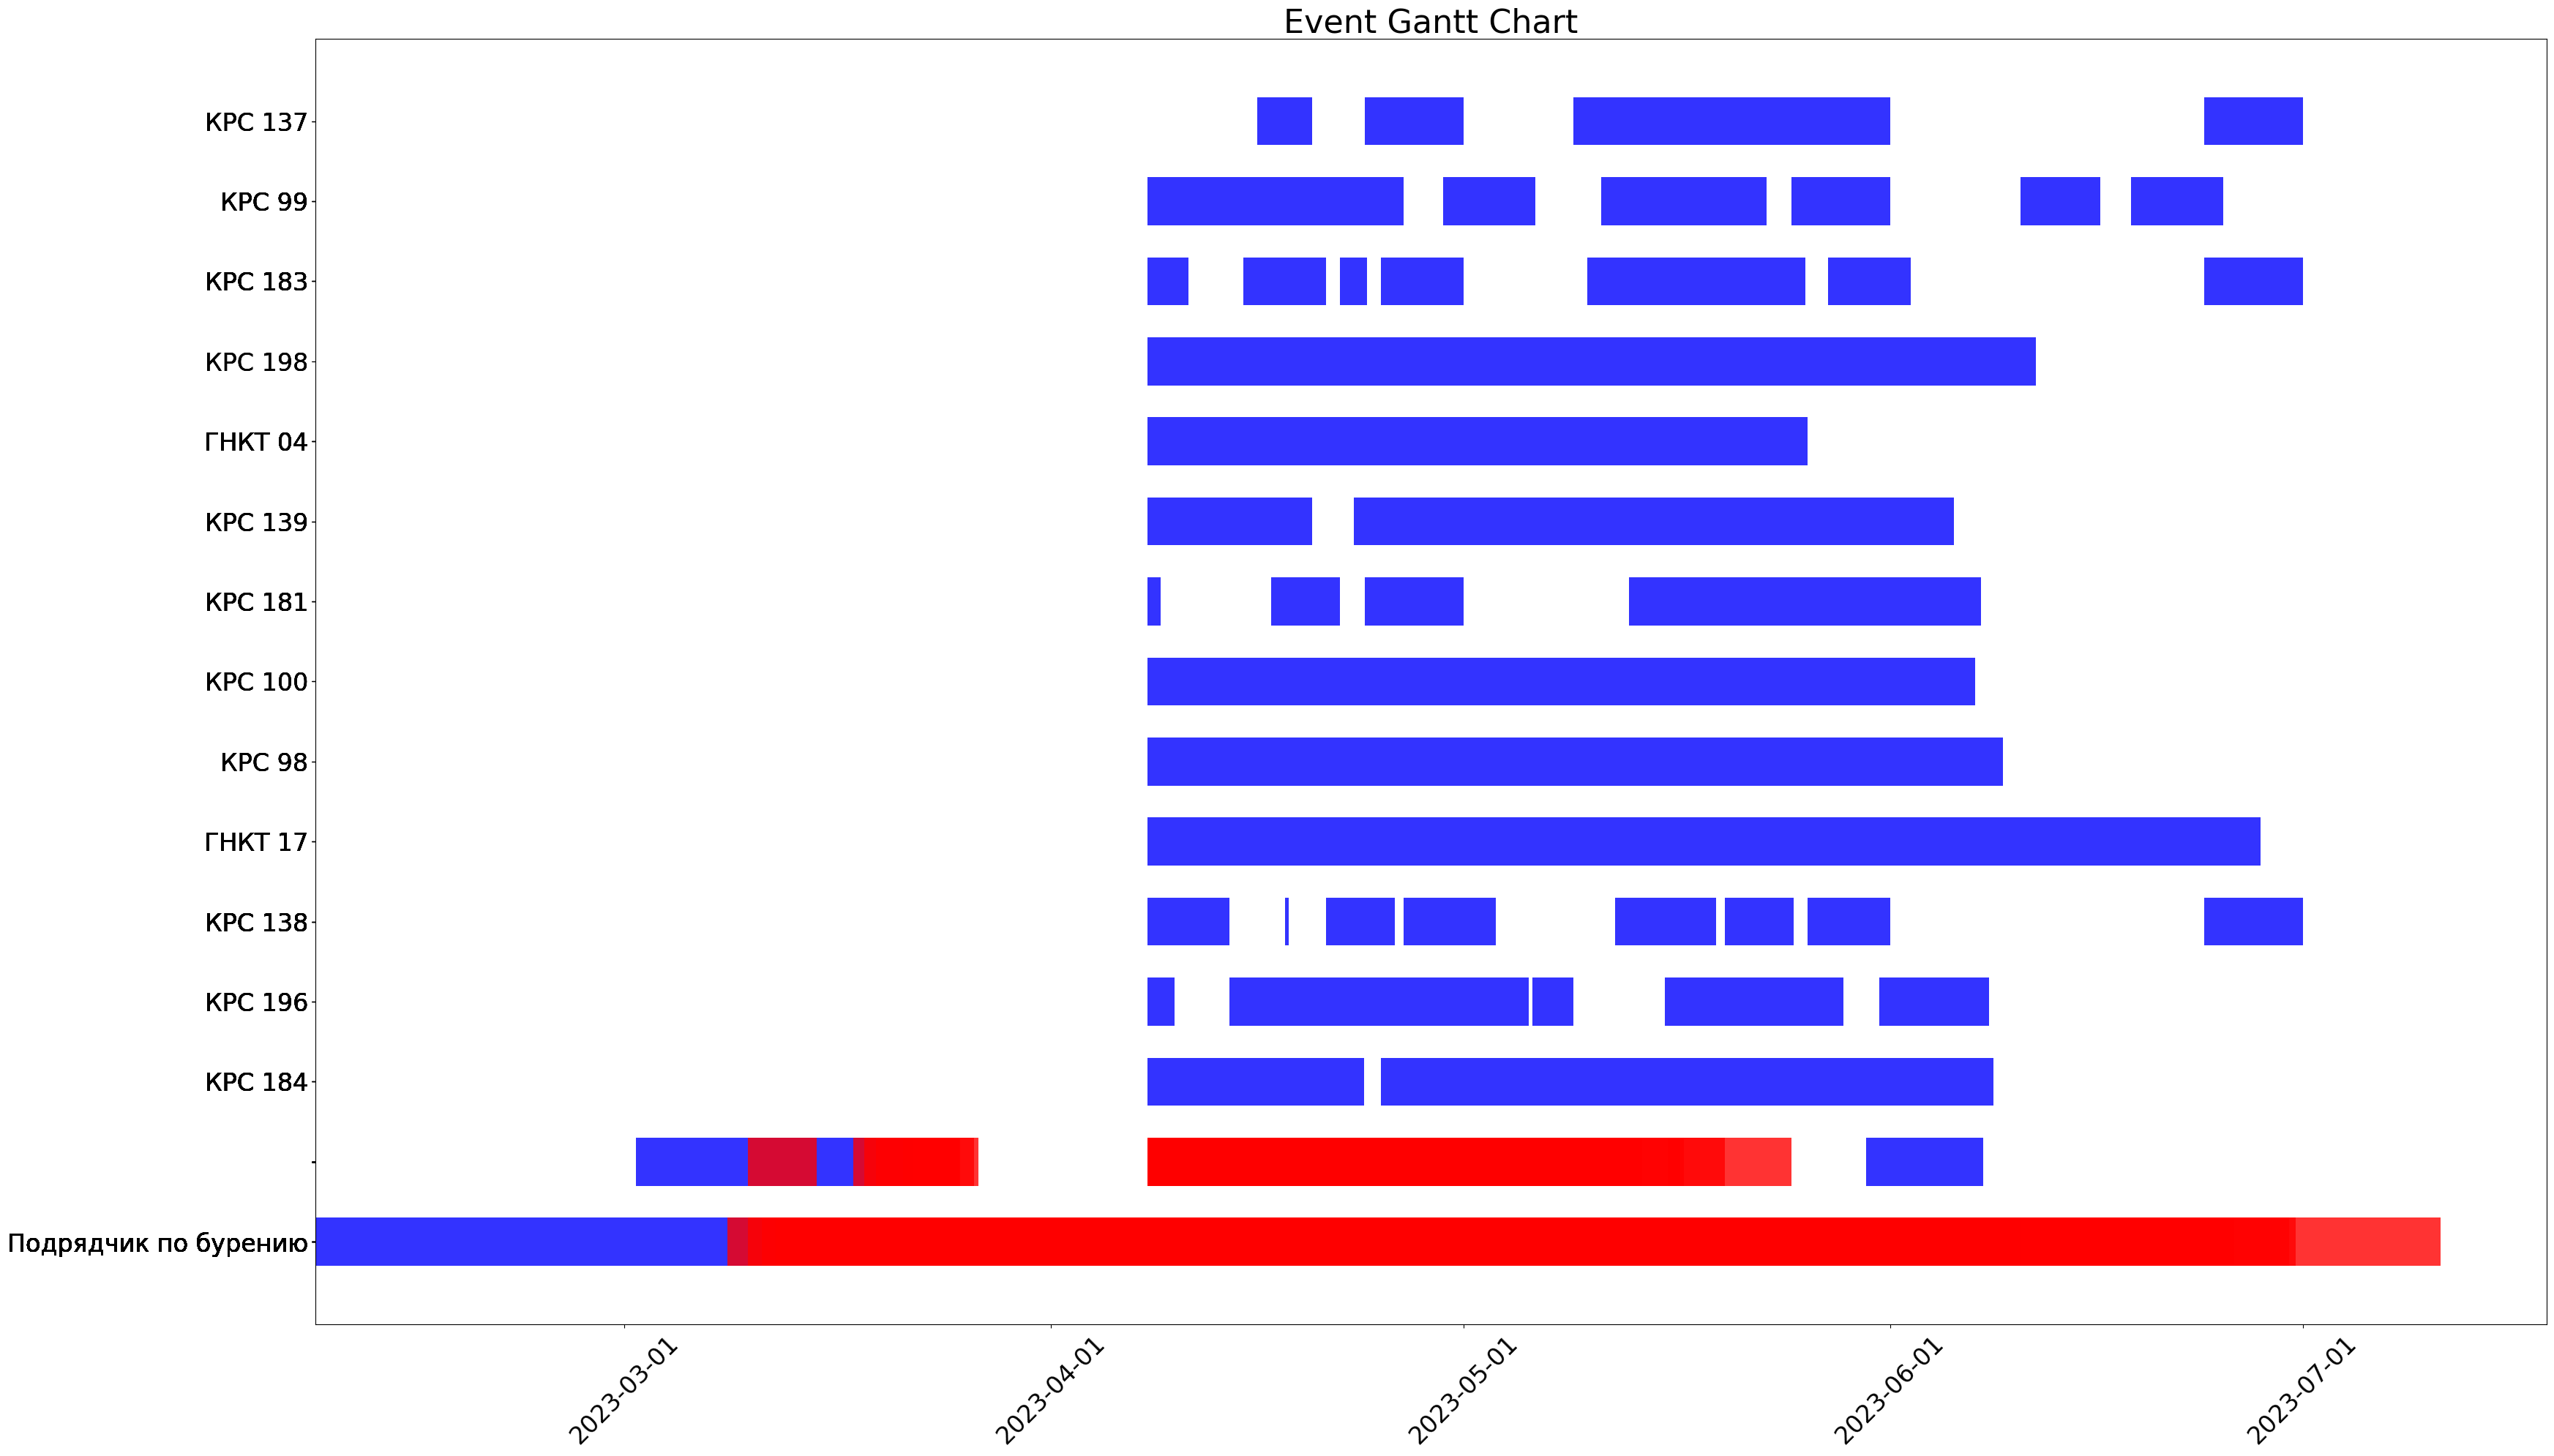

In [78]:
plan['repair_begin_date'] = pd.to_datetime(plan['repair_begin_date'])
plan['repair_end_date'] = pd.to_datetime(plan['repair_end_date'])

# Sort the dataframe based on the 'repair_begin_date' column
plan = plan.sort_values(by='repair_begin_date')

# Create a new column for the duration of each repair
plan['duration'] = plan['repair_end_date'] - plan['repair_begin_date']

# Assign a unique number for each distinct 'Скважина' value
plan['skv_num'] = pd.factorize(plan['brigade_n'])[0]

# Create a new figure and axes for the Gantt chart
fig, ax = plt.subplots(figsize=(35, 20))  # Increase the figure size

# Dictionary to store intersecting events for each well
intersecting_events = {}

# Plot horizontal bars for each repair
for i, row in plan.iterrows():
    skv_num = row['skv_num']
    if skv_num not in intersecting_events:
        intersecting_events[skv_num] = []
    intersecting = []
    for event in intersecting_events[skv_num]:
        if event['repair_end_date'] > row['repair_begin_date'] and event['repair_begin_date'] < row['repair_end_date']:
            intersecting.append(event)
    if intersecting:
        intersecting_events[skv_num].append(row)
        color = 'red'
    else:
        intersecting_events[skv_num] = [row]
        color = 'blue'
    ax.barh(skv_num, row['duration'], left=row['repair_begin_date'], height=0.6, align='center', alpha=0.8, color=color)

# Set y-axis ticks and labels with increased font size
ax.set_yticks(plan['skv_num'])
ax.set_yticklabels(plan['brigade_n'], fontsize=24)  # Increase the font size

# Format x-axis as dates with increased font size
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=24)  # Increase the font size

# Set the chart title with increased font size
ax.set_title('Event Gantt Chart', fontsize=32)  # Increase the font size

# Show the chart
plt.tight_layout()
plt.show()

In [79]:
plan['repair_begin_date'] = pd.to_datetime(plan['repair_begin_date'])
plan['repair_end_date'] = pd.to_datetime(plan['repair_end_date'])

# Sort the dataframe based on the 'repair_begin_date' column
plan = plan.sort_values(by='repair_begin_date')

# Create a new column for the duration of each repair
plan['duration'] = plan['repair_end_date'] - plan['repair_begin_date']

# Assign a unique number for each distinct 'Скважина' value
plan['skv_num'] = pd.factorize(plan['Скважина'])[0]

# Create a new figure and axes for the Gantt chart
fig, ax = plt.subplots(figsize=(100, 60))  # Increase the figure size

# Dictionary to store intersecting events for each well
intersecting_events = {}

# Plot horizontal bars for each repair
for i, row in plan.iterrows():
    skv_num = row['skv_num']
    if skv_num not in intersecting_events:
        intersecting_events[skv_num] = []
    intersecting = []
    for event in intersecting_events[skv_num]:
        if event['repair_end_date'] > row['repair_begin_date'] and event['repair_begin_date'] < row['repair_end_date']:
            intersecting.append(event)
    if intersecting:
        intersecting_events[skv_num].append(row)
        color = 'red'
    else:
        intersecting_events[skv_num] = [row]
        color = 'blue'
    ax.barh(skv_num, row['duration'], left=row['repair_begin_date'], height=0.6, align='center', alpha=0.8, color=color)

# Set y-axis ticks and labels with increased font size
ax.set_yticks(plan['skv_num'])
ax.set_yticklabels(plan['Скважина'], fontsize=32)  # Increase the font size

# Format x-axis as dates with increased font size
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=32)  # Increase the font size

# Set the chart title with increased font size
ax.set_title('Event Gantt Chart', fontsize=96)  # Increase the font size

# Show the chart
plt.tight_layout()
plt.show()

In [80]:
plan_unnum = pd.DataFrame({'id Планируемого мероприятия  KS': [event_id[i] for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''], 
                    'id Мероприятия (из мастер-системы)': [event_system[i] for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''], 
                    'Номер Исполнителя': [crew_num[15] if event_idsystem[i] == 1 else '' if crew_num[planned_events[i]['brig']] == -1 else crew_num[planned_events[i]['brig']] for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''], 
                    'id Исполнителя': [crew_name[15] if event_idsystem[i] == 1 else '' if crew_name[planned_events[i]['brig']] == -1 else crew_name[planned_events[i]['brig']] for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''], 
                    'Дата начала мероприятия': [planned_events[i]['start'] for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''], 
                    'Дата окончания мероприятия': [planned_events[i]['finish'] for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''],
                    'Дата начала простоя': [planned_events[i]['start'] + timedelta(hours=event_IdleStart[i])  for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != ''], 
                    'Дата окончания простоя': [planned_events[i]['finish'] + timedelta(hours=event_downtime[i]) for i in planned_events if event_system[i] == '777777' and planned_events[i]['start'] != '']})

In [81]:
plan_unnum.to_excel('./result_unnum.xlsx', index=False)
